In [19]:
import time
import json
from optparse import OptionParser
import sys
import os
cwd = os.getcwd()
moduledir = cwd+'/../modules/'
if moduledir not in sys.path:
    sys.path.append(moduledir)
from analysis_process import *

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', dpi=300)


# Load configuration and processed MC

In [3]:
configFile = "/data/user/ssarkar/github_repo/DiMuonAnalysis/config/mc_config.json"
with open(configFile) as f:
        config = json.load(f)
asimov = True

#global switch for printing stuff
quiet = True


In [4]:
datafile = '/data/user/ssarkar/github_repo/DiMuonAnalysis/process_data/MC_Processed.h5'

h5data = h5.File(datafile, 'r')
#define the h5 file group and dataset names
bkg = h5data['background']
sig = h5data['signal']
bkg_names = ['numu_nom+sys',
               'nutau_nom',
               'nue_nom',
               'muon_nom',
               'dom1_sys',
               'dom2_sys',
               'hole1_sys',
               'hole2_sys',
               'bulk_sys']
sig_names = ['charm_nom+sys',
            'trident_nom',
            'dom1_sys',
            'dom2_sys',
            'hole1_sys',
            'hole2_sys',
            'bulk1_sys',
            'bulk2_sys',
            'bulk3_sys',
            'bulk4_sys']

In [5]:
sig_holder = []
bkg_holder = []
sigsys_holder = []
bkgsys_holder = []

for i,name in enumerate(bkg_names):
    dataset = bkg[name]
    process = LoadProcessed(dataset)
    if i<4:
        bkg_holder.append(process)
    else:
        bkgsys_holder.append(process)
        
for i,name in enumerate(sig_names):
    dataset = sig[name]
    process = LoadProcessed(dataset)
    if i<2:
        sig_holder.append(process)
    else:
        sigsys_holder.append(process)

# Load Data

In [6]:
configFile = "/data/user/ssarkar/github_repo/DiMuonAnalysis/config/fulldata_config.json"

with open(configFile) as f:
        configData = json.load(f)

print ("Processing Data...")
#Process the data
infiles = [configData["Input"]["data_loc"]+f for f in configData["Input"]["filenames"]]
ascores = [configData["Input"]["score_loc"]+f for f in configData["Input"]["Ascores"]]
bscores = [configData["Input"]["score_loc"]+f for f in configData["Input"]["Bscores"]]


data = AnalysisCutV2(infiles, ascores, bscores, None)
print ("Applying cut regions and getting event counts...")
#Get events in each cut regions
reglist = config["CutRegions"]
for key, value in reglist.items():
    if not(quiet):
        print (f"---------------{key}-----------------")
        print (get_DataCounts(data, value))


Processing Data...
Processing files for building final arrays... Will take a while.
Done building arrays!
Applying cut regions and getting event counts...


In [7]:
#=============== Get final event counts in  Cut regions
reglist = config["CutRegions"]
wtsyslist = config["WeightSystematics"]

#set up output directory
outdir = config["Output"]["outdir"]
if outdir is None:
    if not(quiet):
        print (f"Output directory not specified in config. Will be storing output in current directory {cwd}")
    outdir = cwd+'/'


In [8]:
livetime = config["Livetimes"]["fullsample"]
print ("Computing MC expectations for 10.67 Years (Full Sample Livetime): ")
for key, value in reglist.items():
    tot, bkg, sig = get_MCCounts(sig_holder, bkg_holder,
                         sigsys_holder, bkgsys_holder, wtsyslist, value, livetime)
    if not(quiet):
        print (f"---------------Event Expectation in {key}-----------------")
        print (f"Total (S+B)    : {tot[0]}")
        print (f"Signal (S)     : {sig[0]}")
        print (f"Background (B) : {bkg[0]}")

outfile = outdir+config["Output"]["outfiles"]["mc_full"]
if not(quiet):
    print (f"Storing expectations in pickle file: {outfile}")

outfile_asimov = None
if asimov:
    outfile_asimov = outdir+config["Output"]["outfiles"]["mc_asimov"]
    if not(quiet):
        print (f"Will be generating asimov dataset in {outfile_asimov}")

#generate_mcPickle(reglist, sig_holder, bkg_holder, sigsys_holder, bkgsys_holder, wtsyslist,
#                livetime, outfile, asimovfile=outfile_asimov)



Computing MC expectations for 10.67 Years (Full Sample Livetime): 


# Cross-check individual distributions

In [9]:
def get_hist(proc, prop, bins, cut=True, time=1.0, plot=False, **kwargs):
    bincen = 0.5*(bins[1:]+bins[:-1])
    if cut:
        n,_ = np.histogram(proc.event_arr[proc.event_idx][prop], bins=bins,
                          weights=proc.event_arr[proc.event_idx]['weight']*time)
        nerr = np.sqrt(np.histogram(proc.event_arr[proc.event_idx][prop], bins=bins,
                        weights=(proc.event_arr[proc.event_idx]['weight']**2)*time)[0])

    else:
        n,_ = np.histogram(proc.event_arr[prop], bins=bins,
                          weights=proc.event_arr['weight']*time)
        nerr = np.sqrt(np.histogram(proc.event_arr[prop], bins=bins,
                        weights=(proc.event_arr['weight']**2)*time)[0])
    rate = " : "+ '{:4.3f}'.format(np.sum(n)*1e6) + r' $\mu$Hz'
    if plot:
        plt.stairs(n,bins, color=kwargs['color'], lw=kwargs['lw'],
                  ls=kwargs['ls'], label=kwargs['label']+rate)
        plt.stairs(n+nerr, bins, baseline=n-nerr, fill=True, alpha=0.6,
                  color=kwargs['color'])
        
    return n,nerr



In [10]:
labels = [r'$\nu_{\mu}/\bar{\nu}_{\mu} \rightarrow \mu^{\pm}H$',
          r'$\nu_{\tau}/\bar{\nu}_{\tau} \rightarrow \tau^{\pm}H$',
         r'$\nu_{e}/\bar{\nu}_{e} \rightarrow e^{\pm}H$',
         r'$\nu_{\mu}/\bar{\nu}_{\mu} \rightarrow \mu^{\pm}\mu^{\pm}H$ (Charm)',
          r'$\nu_{\mu}/\bar{\nu}_{\mu} \rightarrow \mu^{\pm}\mu^{\pm}H$ (Trident)',
         r'$\nu_{\tau}/\bar{\nu}_{\tau} \rightarrow \mu^{\pm}\mu^{\pm}H$ (Charm)',
                    'Atm. Muons'
         ]
colors = ['firebrick', 'coral', 'sandybrown',
         'seagreen', 'steelblue', 'turquoise', 'sienna']

In [11]:
for process in sig_holder:
    process.reset_cut()
    process.apply_zenithCut()
    process.apply_energyCut(emin=1e2, emax=1e5)

for process in bkg_holder:
    process.reset_cut()
    process.apply_zenithCut()
    process.apply_energyCut(emin=1e2, emax=1e5)



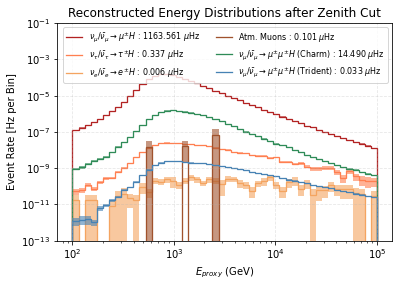

In [12]:
nbins = 50
#ebins = np.logspace(np.log10(1.1e3),np.log10(5e4),nbins+1)
ebins = np.logspace(2,5,nbins+1)

bincen = 0.5*(ebins[1:]+ebins[:-1])

plot_config = {'lw':1.3, 'ls':'-'}

plt.figure()

plot_config['color'] = colors[0]
plot_config['label'] = labels[0]
get_hist(bkg_holder[0], 'etrack', ebins, plot=True, **plot_config)


plot_config['color'] = colors[1]
plot_config['label'] = labels[1]
get_hist(bkg_holder[1], 'etrack', ebins, plot=True, **plot_config)

plot_config['color'] = colors[2]
plot_config['label'] = labels[2]
get_hist(bkg_holder[2], 'etrack', ebins, plot=True, **plot_config)


plot_config['color'] = colors[6]
plot_config['label'] = labels[6]
get_hist(bkg_holder[3], 'etrack', ebins, plot=True, **plot_config)

'''c='sienna'
ncor, _ = np.histogram(enarr, bins=ebins, weights=wtarr)
ncerr = np.sqrt(np.histogram(enarr, bins=ebins, weights=wtarr**2)[0])
plt.stairs(ncor, ebins, color=c, lw=1.3,
           label='Atm. Muons : '+'{:2.2f}'.format(np.sum(ncor)*1e6)+r' $\mu$Hz')
plt.stairs(ncor+ncerr, ebins, baseline=ncor-ncerr, fill=True, alpha=0.6,
          color=c)
'''
plot_config['color'] = colors[3]
plot_config['label'] = labels[3]
get_hist(sig_holder[0], 'etrack', ebins, plot=True, **plot_config)

plot_config['color'] = colors[4]
plot_config['label'] = labels[4]
get_hist(sig_holder[1], 'etrack', ebins, plot=True, **plot_config)

#plot_config['color'] = colors[5]
#plot_config['label'] = labels[5]
#get_hist(sig_holder[2], 'etrack', ebins, plot=True, **plot_config)

#plt.vlines(1.1e3, 1e-17,1e-3, linestyles='--', colors='k')
#plt.vlines(5e4, 1e-17,1e-3, linestyles='--', colors='k')

plt.grid(which='major', alpha=0.3, ls='--')
plt.legend(ncol=2, loc='upper right', fontsize=8)
plt.yscale('log')
plt.xscale('log')
#plt.ylim([1e-17,1e0])
plt.ylim([1e-13,1e-1])
plt.ylabel('Event Rate [Hz per Bin]')
plt.xlabel(r'$E_{proxy}$ (GeV)')
plt.title('Reconstructed Energy Distributions after Zenith Cut')
plt.show()

# Total MC nominal + unc. distributions

In [13]:
def get_totunc_charm(ebins, zbins, abins, bbins):
    avarlist = []
    bvarlist = []
    evarlist = []
    zvarlist = []
    
    #sbins = np.linspace(0,1,31)
    #ebins = np.logspace(np.log10(1.1e3),np.log10(5e4),nbins+1)
    #zbins = np.linspace(-1,0,nbins+1)

    anom,_ = np.histogram(nom_charm.event_arr[nom_charm.event_idx]['apred'], bins=abins,
                   weights=nom_charm.event_arr[nom_charm.event_idx]['weight'])
    bnom,_ = np.histogram(nom_charm.event_arr[nom_charm.event_idx]['bpred'], bins=bbins,
                   weights=nom_charm.event_arr[nom_charm.event_idx]['weight'])
    enom,_ = np.histogram(nom_charm.event_arr[nom_charm.event_idx]['etrack'], bins=ebins,
                   weights=nom_charm.event_arr[nom_charm.event_idx]['weight'])
    znom,_ = np.histogram(nom_charm.event_arr[nom_charm.event_idx]['cosz'], bins=zbins,
                   weights=nom_charm.event_arr[nom_charm.event_idx]['weight'])

    for process in sigsys_holder:
        anum,_ = np.histogram(process.event_arr[process.event_idx]['apred'], bins=abins,
                       weights=process.event_arr[process.event_idx]['weight'])
        bnum,_ = np.histogram(process.event_arr[process.event_idx]['bpred'], bins=bbins,
                       weights=process.event_arr[process.event_idx]['weight'])
        enum,_ = np.histogram(process.event_arr[process.event_idx]['etrack'], bins=ebins,
                       weights=process.event_arr[process.event_idx]['weight'])
        znum,_ = np.histogram(process.event_arr[process.event_idx]['cosz'], bins=zbins,
                       weights=process.event_arr[process.event_idx]['weight'])
        avar = (anum/anom-1)
        bvar = (bnum/bnom-1)
        evar = (enum/enom - 1)
        zvar = (znum/znom-1)
    
        avarlist.append(avar)
        bvarlist.append(bvar)
        evarlist.append(evar)
        zvarlist.append(zvar)

    syslist = ['XS','ConvNorm','ConvGamma', 'AstroNorm', 'AstroGamma']

    for sys in syslist:
        a1num, _ = np.histogram(nom_charm.event_arr[nom_charm.event_idx]['apred'], bins=abins,
                           weights=nom_charm.event_arr[nom_charm.event_idx][sys+'UP'])
        a2num, _ = np.histogram(nom_charm.event_arr[nom_charm.event_idx]['apred'], bins=abins,
                           weights=nom_charm.event_arr[nom_charm.event_idx][sys+'DN'])
        a1var = (a1num/anom - 1)
        a2var = (a2num/anom - 1)
    
        avarlist.append(a1var)
        avarlist.append(a2var)
    
        b1num, _ = np.histogram(nom_charm.event_arr[nom_charm.event_idx]['bpred'], bins=bbins,
                           weights=nom_charm.event_arr[nom_charm.event_idx][sys+'UP'])
        b2num, _ = np.histogram(nom_charm.event_arr[nom_charm.event_idx]['bpred'], bins=bbins,
                           weights=nom_charm.event_arr[nom_charm.event_idx][sys+'DN'])
        b1var = (b1num/bnom - 1)
        b2var = (b2num/bnom - 1)
    
        bvarlist.append(b1var)
        bvarlist.append(b2var)
        
        #----------------------------
        a1num, _ = np.histogram(nom_charm.event_arr[nom_charm.event_idx]['etrack'], bins=ebins,
                           weights=nom_charm.event_arr[nom_charm.event_idx][sys+'UP'])
        a2num, _ = np.histogram(nom_charm.event_arr[nom_charm.event_idx]['etrack'], bins=ebins,
                           weights=nom_charm.event_arr[nom_charm.event_idx][sys+'DN'])
        a1var = (a1num/enom - 1)
        a2var = (a2num/enom - 1)
    
        evarlist.append(a1var)
        evarlist.append(a2var)
    
        b1num, _ = np.histogram(nom_charm.event_arr[nom_charm.event_idx]['cosz'], bins=zbins,
                           weights=nom_charm.event_arr[nom_charm.event_idx][sys+'UP'])
        b2num, _ = np.histogram(nom_charm.event_arr[nom_charm.event_idx]['cosz'], bins=zbins,
                           weights=nom_charm.event_arr[nom_charm.event_idx][sys+'DN'])
        b1var = (b1num/znom - 1)
        b2var = (b2num/znom - 1)
    
        zvarlist.append(b1var)
        zvarlist.append(b2var)

    return evarlist, zvarlist, avarlist, bvarlist

In [14]:
def get_totunc_ccdis(ebins, zbins, abins, bbins):
    avarlist = []
    bvarlist = []
    evarlist = []
    zvarlist = []
    
    #sbins = np.linspace(0,1,31)
    #ebins = np.logspace(np.log10(1.1e3),np.log10(5e4),nbins+1)
    #zbins = np.linspace(-1,0,nbins+1)

    anom,_ = np.histogram(nom_ccdis.event_arr[nom_ccdis.event_idx]['apred'], bins=abins,
                   weights=nom_ccdis.event_arr[nom_ccdis.event_idx]['weight'])
    bnom,_ = np.histogram(nom_ccdis.event_arr[nom_ccdis.event_idx]['bpred'], bins=bbins,
                   weights=nom_ccdis.event_arr[nom_ccdis.event_idx]['weight'])
    enom,_ = np.histogram(nom_ccdis.event_arr[nom_ccdis.event_idx]['etrack'], bins=ebins,
                   weights=nom_ccdis.event_arr[nom_ccdis.event_idx]['weight'])
    znom,_ = np.histogram(nom_ccdis.event_arr[nom_ccdis.event_idx]['cosz'], bins=zbins,
                   weights=nom_ccdis.event_arr[nom_ccdis.event_idx]['weight'])

    for process in ccdis_holder[1:]:
        anum,_ = np.histogram(process.event_arr[process.event_idx]['apred'], bins=abins,
                       weights=process.event_arr[process.event_idx]['weight'])
        bnum,_ = np.histogram(process.event_arr[process.event_idx]['bpred'], bins=bbins,
                       weights=process.event_arr[process.event_idx]['weight'])
        enum,_ = np.histogram(process.event_arr[process.event_idx]['etrack'], bins=ebins,
                       weights=process.event_arr[process.event_idx]['weight'])
        znum,_ = np.histogram(process.event_arr[process.event_idx]['cosz'], bins=zbins,
                       weights=process.event_arr[process.event_idx]['weight'])

        avar = (anum/anom-1)
        bvar = (bnum/bnom-1)
        evar = (enum/enom-1)
        zvar = (znum/znom-1)
    
        avarlist.append(avar)
        bvarlist.append(bvar)
        evarlist.append(evar)
        zvarlist.append(zvar)

    syslist = ['XS','ConvNorm','ConvGamma', 'AstroNorm', 'AstroGamma']

    for sys in syslist:
        a1num, _ = np.histogram(nom_ccdis.event_arr[nom_ccdis.event_idx]['apred'], bins=abins,
                           weights=nom_ccdis.event_arr[nom_ccdis.event_idx][sys+'UP'])
        a2num, _ = np.histogram(nom_ccdis.event_arr[nom_ccdis.event_idx]['apred'], bins=abins,
                           weights=nom_ccdis.event_arr[nom_ccdis.event_idx][sys+'DN'])
        a1var = (a1num/anom - 1)
        a2var = (a2num/anom - 1)
    
        avarlist.append(a1var)
        avarlist.append(a2var)
    
        b1num, _ = np.histogram(nom_ccdis.event_arr[nom_ccdis.event_idx]['bpred'], bins=bbins,
                           weights=nom_ccdis.event_arr[nom_ccdis.event_idx][sys+'UP'])
        b2num, _ = np.histogram(nom_ccdis.event_arr[nom_ccdis.event_idx]['bpred'], bins=bbins,
                           weights=nom_ccdis.event_arr[nom_ccdis.event_idx][sys+'DN'])
        b1var = (b1num/bnom - 1)
        b2var = (b2num/bnom - 1)
    
        bvarlist.append(b1var)
        bvarlist.append(b2var)
        
        #----------------------------
        a1num, _ = np.histogram(nom_ccdis.event_arr[nom_ccdis.event_idx]['etrack'], bins=ebins,
                           weights=nom_ccdis.event_arr[nom_ccdis.event_idx][sys+'UP'])
        a2num, _ = np.histogram(nom_ccdis.event_arr[nom_ccdis.event_idx]['etrack'], bins=ebins,
                           weights=nom_ccdis.event_arr[nom_ccdis.event_idx][sys+'DN'])
        a1var = (a1num/enom - 1)
        a2var = (a2num/enom - 1)
    
        evarlist.append(a1var)
        evarlist.append(a2var)
    
        b1num, _ = np.histogram(nom_ccdis.event_arr[nom_ccdis.event_idx]['cosz'], bins=zbins,
                           weights=nom_ccdis.event_arr[nom_ccdis.event_idx][sys+'UP'])
        b2num, _ = np.histogram(nom_ccdis.event_arr[nom_ccdis.event_idx]['cosz'], bins=zbins,
                           weights=nom_ccdis.event_arr[nom_ccdis.event_idx][sys+'DN'])
        b1var = (b1num/znom - 1)
        b2var = (b2num/znom - 1)
    
        zvarlist.append(b1var)
        zvarlist.append(b2var)

    return evarlist, zvarlist, avarlist, bvarlist

In [15]:
def get_tot(avarlist):
    #calculate total systematics variation
    sdom = np.maximum(avarlist[0], avarlist[1])
    shole = np.maximum(avarlist[2], avarlist[3])

    sbulk1 = np.maximum(avarlist[4], avarlist[5])
    sbulk2 = np.maximum(avarlist[6], avarlist[7])
    sbulk = np.maximum(sbulk1, sbulk2)

    sxs = np.maximum(avarlist[8],avarlist[9])
    scnorm = np.maximum(avarlist[10],avarlist[11])
    scgamma = np.maximum(avarlist[12],avarlist[13])
    sanorm = np.maximum(avarlist[14],avarlist[15])
    sagamma = np.maximum(avarlist[16],avarlist[17])

    stot = np.sqrt(sdom**2+shole**2+sbulk**2+sxs**2+scnorm**2+scgamma**2+sanorm**2+sagamma**2)
    return stot

def get_tot1(ccbvarlist):
    bdom = np.maximum(ccbvarlist[0], ccbvarlist[1])
    bhole = np.maximum(ccbvarlist[2], ccbvarlist[3])

    bbulk = ccbvarlist[4]

    bxs = np.maximum(ccbvarlist[5],ccbvarlist[6])
    bcnorm = np.maximum(ccbvarlist[7],ccbvarlist[8])
    bcgamma = np.maximum(ccbvarlist[9],ccbvarlist[10])
    banorm = np.maximum(ccbvarlist[11],ccbvarlist[12])
    bagamma = np.maximum(ccbvarlist[13],ccbvarlist[14])

    btot = np.sqrt(bdom**2+bhole**2+bbulk**2+bxs**2+bcnorm**2+bcgamma**2+banorm**2+bagamma**2)

    return btot


In [16]:
TIME = config['Livetimes']['fullsample']
print (TIME)

336452722.546


In [17]:
# define the holder lists
nom_charm = sig_holder[0]
nom_ccdis = bkg_holder[0]
charm_holder = [nom_charm]+sigsys_holder
ccdis_holder = [nom_ccdis]+bkgsys_holder

# Configure Cut Regions

In [343]:
XLABELS = {'etrack' : r'$E_{proxy}$ (GeV)',
          'cosz' : r'$Cos(Zenith_{reco})$',
          'apred' : 'GNetA Score',
          'bpred' : 'GNetB Score'}
REGIONS = {'TOT' : "All Scores",
          'CR' : "Control Region",
          'VR1' : "Validation Region 1 (VR1)",
          'VR2' : "Validation Region 2 (VR2)",
          'VR3' : "Validation Region 3 (VR3)",
          'VR4' : "Validation Region 4 (VR4)",
          'ROI' : "Region of Interest (ROI)",
           'SR1' : "Signal Region 1 (SR1)",
           'SR2' : "Signal Region 2 (SR2)",
           'SR3' : "Signal Region 3 (SR3)"
          }
#define the plot configurations

#fname = "../plots/plot_config.json"

fname = "../plots/plot_config_postfit.json"

with open(fname) as f:
    pltcnf = json.load(f)



In [344]:
#allsett = pltcnf['all']
#allsett = pltcnf['roi']
allsett = pltcnf['cr']
#allsett = pltcnf['vr1']
#allsett = pltcnf['vr2']
#allsett = pltcnf['vr3']
#allsett = pltcnf['vr4']

In [345]:
reg = config['CutRegions'][allsett['reg']]
nbins = allsett['nbins']
amin = allsett['amin']
amax = allsett['amax']
bmin = allsett['bmin']
bmax = allsett['bmax']
emin = allsett['emin']
emax = allsett['emax']
zmin = allsett['zmin']
zmax = allsett['zmax']

ebins = np.logspace(np.log10(emin),np.log10(emax),nbins+1)
zbins = np.linspace(zmin,zmax,nbins+1)
abins = np.linspace(amin,amax,nbins+1)
bbins = np.linspace(bmin,bmax,nbins+1)

In [346]:
for process in sig_holder:
    process.reset_cut()
    process.apply_energyCut()
    process.apply_zenithCut()
    process.apply_boxCut(reg[1][0], reg[1][1],
                       amax=reg[1][2], bmax=reg[1][3])

for process in bkg_holder:
    process.reset_cut()
    process.apply_energyCut()
    process.apply_zenithCut()
    process.apply_boxCut(reg[1][0], reg[1][1],
                       amax=reg[1][2], bmax=reg[1][3])

for process in sigsys_holder:
    process.reset_cut()
    process.apply_energyCut()
    process.apply_zenithCut()
    process.apply_boxCut(reg[1][0], reg[1][1],
                       amax=reg[1][2], bmax=reg[1][3])

for process in bkgsys_holder:
    process.reset_cut()
    process.apply_energyCut()
    process.apply_zenithCut()
    process.apply_boxCut(reg[1][0], reg[1][1],
                       amax=reg[1][2], bmax=reg[1][3])


data.reset_cut()
data.apply_energyCut()
data.apply_zenithCut()
data.apply_boxCut(reg[1][0], reg[1][1],
                       amax=reg[1][2], bmax=reg[1][3])

In [347]:
sigerr = get_totunc_charm(ebins, zbins, abins, bbins)

In [348]:
bkgerr = get_totunc_ccdis(ebins, zbins, abins, bbins)

In [349]:
senerr = get_tot(sigerr[0])
sznerr = get_tot(sigerr[1])
saperr = get_tot(sigerr[2])
sbperr = get_tot(sigerr[3])

In [350]:
benerr = get_tot1(bkgerr[0])
bznerr = get_tot1(bkgerr[1])
baperr = get_tot1(bkgerr[2])
bbperr = get_tot1(bkgerr[3])

In [351]:
def get_hist(p, prop, bins, TIME):
    #time = 0.76*365*24*60*60
    s,_ = np.histogram(p.event_arr[p.event_idx][prop], bins=bins,
                   weights=p.event_arr[p.event_idx]['weight']*TIME)
    return s

def get_mcerr(p, prop, bins, TIME):
    serr = np.sqrt(np.histogram(p.event_arr[p.event_idx][prop],
                    bins=bins,
#                    weights=(p.event_arr[p.event_idx]['weight']**2)*TIME)[0])
                    weights=(p.event_arr[p.event_idx]['weight']*TIME)**2)[0])
    return serr

def make_histplot(prop, bins, sigerror, bkgerror,
                  tottime = TIME, 
                  bkg_scale = 1.0, sig_scale = 1.0,
                  plot_err = True,
                  i3label = False, plot_mcerr=False,
                  **kwargs):
    #get the binnings for MC
    bincen = 0.5*(bins[1:]+bins[:-1])
    bindiff = np.diff(bins)/2.
    
    b1 = get_hist(bkg_holder[0], prop, bins, tottime)
    b2 = get_hist(bkg_holder[1], prop, bins, tottime)
    b3 = get_hist(bkg_holder[2], prop, bins, tottime)
    b4 = get_hist(bkg_holder[3], prop, bins, tottime)

    s1 = get_hist(sig_holder[0], prop, bins, tottime)
    s2 = get_hist(sig_holder[1], prop, bins, tottime)

    if plot_mcerr:
        bkg_mcerr = np.zeros_like(b1)
        sig_mcerr = np.zeros_like(s1)
        for b in bkg_holder:
            err = get_mcerr(b, prop, bins, tottime)
            bkg_mcerr += err**2
        for s in sig_holder:
            err = get_mcerr(s, prop, bins, tottime)
            sig_mcerr += err**2

        tot_mcerr = np.sqrt(bkg_mcerr + sig_mcerr)
        #print (tot_mcerr)
        
    tot_bkg = (b1+b2+b3+b4) * bkg_scale
    tot_sig = (s1+s2) * sig_scale
    tot = tot_bkg + tot_sig
    
    totup = tot + b1*bkg_scale*bkgerror + s1*sig_scale*sigerror
    totdn = tot - b1*bkg_scale*bkgerror - s1*sig_scale*sigerror
    
    #get the binnings for data
    ndata,_ = np.histogram(data.event_arr[data.event_idx][prop], bins=bins)
    nerr = np.sqrt(ndata)
    
    #Plot
    if 'fsize' in kwargs.keys():
        fig = plt.figure(figsize=tuple(kwargs['fsize']))
    else:
        fig = plt.figure()
    
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=kwargs['hratio'])
    axs = gs.subplots(sharex=True)

    #plot MC
    axs[0].stairs(tot_bkg, bins, baseline = np.zeros(len(tot_bkg)), 
             **kwargs['bkg_settings'])

    axs[0].stairs(tot_sig+tot_bkg, bins, baseline = tot_bkg, 
             **kwargs['sig_settings'])

    if plot_err and not(plot_mcerr):
        axs[0].stairs(totup, bins, baseline=totdn, fill=False,
                  label = r"Total Prior Unc. ($\pm 1\sigma$)",
                **kwargs['unc_settings'])
    if plot_err and plot_mcerr:
        axs[0].stairs(tot+tot_mcerr, bins, baseline=tot-tot_mcerr, fill=False,
                     label = r"Total MC Stat. Unc.",
                     **kwargs['unc_settings'])
    #plot Data
    axs[0].errorbar(bincen, ndata, yerr=nerr,
                    **kwargs['data_settings'])

    #apply axis settings
    axs[0].grid(**kwargs['grid'])
    axsett = kwargs[prop+'_scale']
    if i3label:
        axs[0].text(axsett['textpos'][0], axsett['textpos'][1],
                 "IceCube Preliminary", 
                    fontsize=12, color='r', fontweight='extra bold')
    
    axs[0].legend(**axsett['legend'])
    axs[0].set_xscale(axsett['xscale'])
    axs[0].set_yscale(axsett['yscale'])

    axs[0].set_ylabel(axsett['ylabel'])
    #axs[0].set_title(f"LiveTime: {tottime/(365.*24*60*60):.2f} Years, Total Events : {np.sum(ndata)}")
    axs[0].set_title(f"{REGIONS[kwargs['reg']]}, Total Observed Events : {np.sum(ndata)}")
    if axsett['xmin'] and axsett['xmax']:
        axs[0].set_xlim([axsett['xmin'], axsett['xmax']])
        axs[1].set_xlim([axsett['xmin'], axsett['xmax']])
        
    if axsett['ax1min'] and axsett['ax1max']:
        axs[0].set_ylim([axsett['ax1min'],
                        axsett['ax1max']])
        
    # Ratio plots
    if not(plot_mcerr):
        axs[1].stairs(totup/tot, bins, baseline=totdn/tot,
                 **allsett['ratio_band'])
    if plot_mcerr:
        axs[1].stairs(1+tot_mcerr/tot, bins,
                      baseline=1-tot_mcerr/tot,
                     **allsett['ratio_band'])

    axs[1].hlines(1, axsett['ratio_line']['min'], axsett['ratio_line']['max'],
                  **axsett['ratio_line']['settings'])
    
    axs[1].errorbar(bincen, ndata/tot, yerr=nerr/tot, xerr=bindiff,
                **allsett['ratio_errorbar'])

    axs[1].grid(**kwargs['grid'])
    axs[1].set_ylabel("Data/MC")
    axs[1].set_xlabel(XLABELS[prop])
    if axsett['ax2min'] and axsett['ax2max']:
        axs[1].set_ylim([axsett['ax2min'],
                        axsett['ax2max']])


    plt.show()

# All, CR, VRs, ROI (Box Cuts)

In [352]:
#Reload the config file for trying out different plotting schemes
#define the plot configurations

#fname = "../plots/plot_config.json"

fname = "../plots/plot_config_postfit.json"

with open(fname) as f:
    pltcnf = json.load(f)

#allsett = pltcnf['all']
allsett = pltcnf['cr']
#allsett = pltcnf['roi']
#allsett = pltcnf['vr1']
#allsett = pltcnf['vr2']
#allsett = pltcnf['vr3']
#allsett = pltcnf['vr4']

In [353]:
fitname = "../plots/fit_config.json"
with open(fitname) as f:
    fitcnf = json.load(f)

#fitsett = fitcnf['sr1']
fitsett = fitcnf['sr2']

# Plot 01: Reconstructed Energy

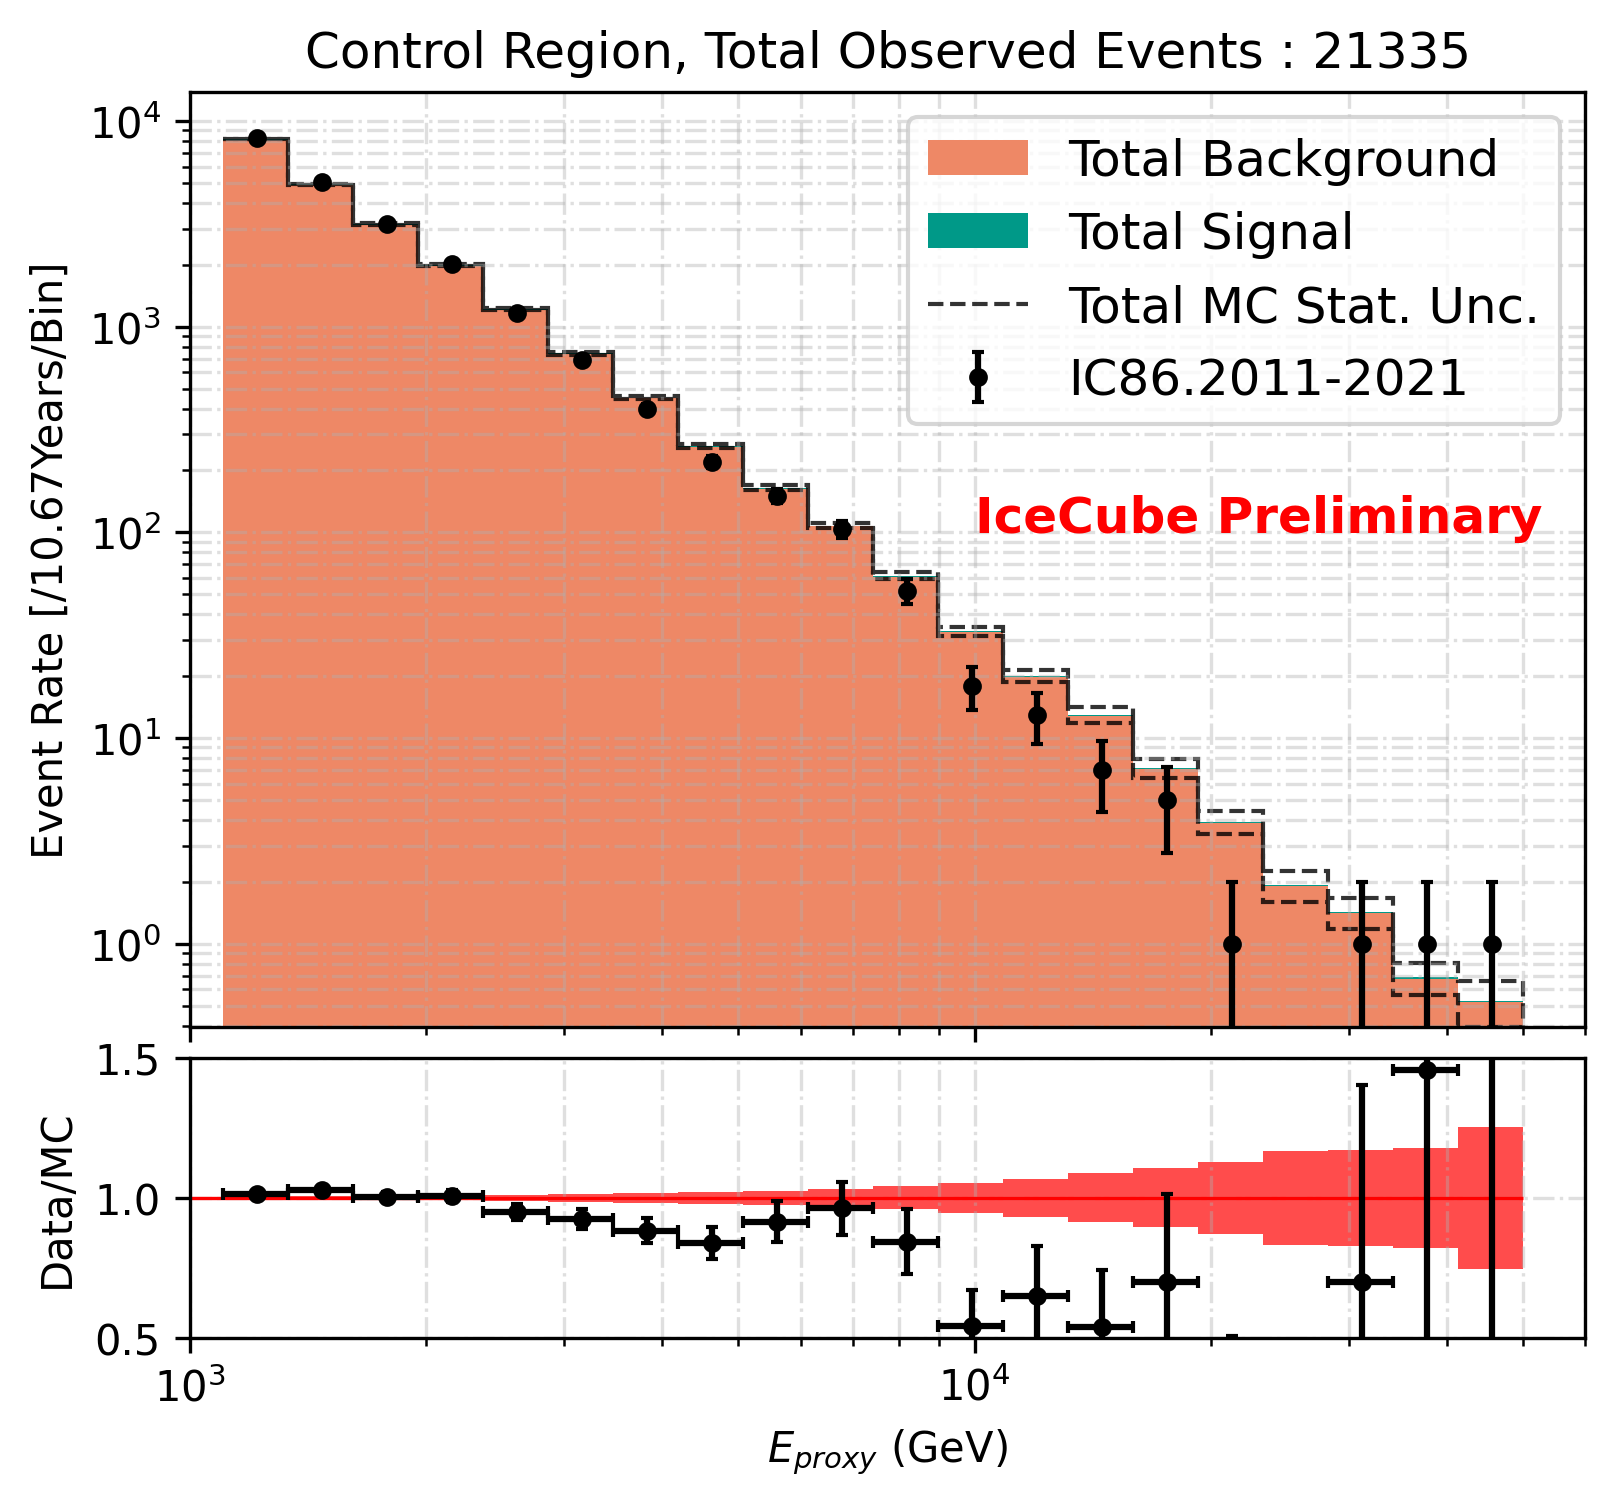

In [354]:
#fit
make_histplot('etrack', ebins, senerr, benerr,
                  tottime = TIME, 
              bkg_scale = fitsett['bkg_scale'],
              sig_scale=fitsett['sig_scale'],
              plot_err=True, plot_mcerr=True,
              i3label=True,
              **allsett)

# Plot 02: Reconstructed Zenith

In [ ]:
make_histplot('cosz', zbins, sznerr, bznerr,
                  tottime = TIME, 
              bkg_scale = fitsett['bkg_scale'],
              sig_scale=fitsett['sig_scale'],
              plot_err=True, plot_mcerr=True,
              i3label=True,
              **allsett)

# Plot 03: GNetA Score

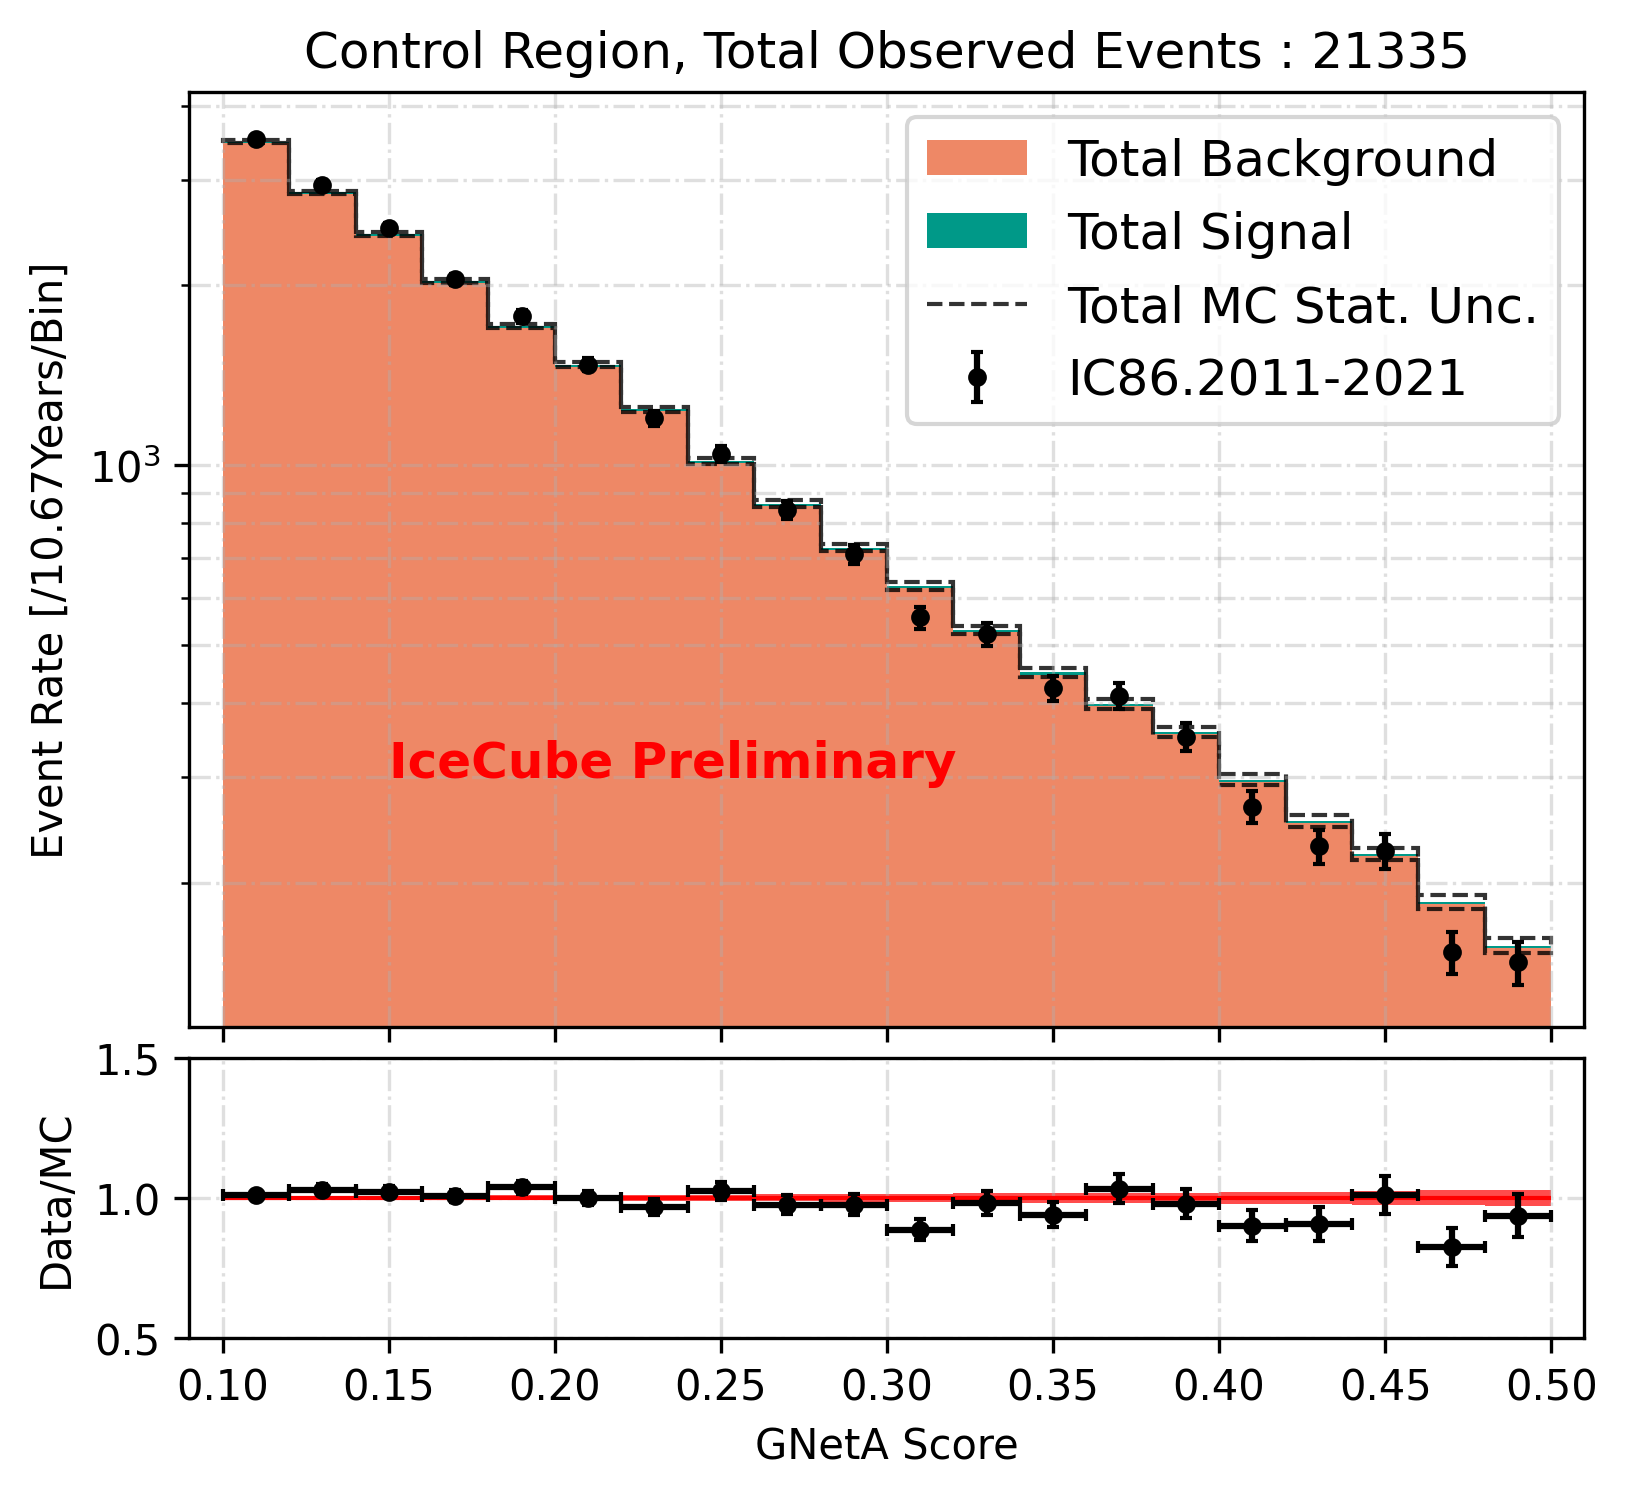

In [356]:
make_histplot('apred', abins, saperr, baperr,
                  tottime = TIME, 
              bkg_scale = fitsett['bkg_scale'],
              sig_scale=fitsett['sig_scale'],
              plot_err=True, plot_mcerr=True,
              i3label=True,
              **allsett)

# Plot 04: GNetB Score

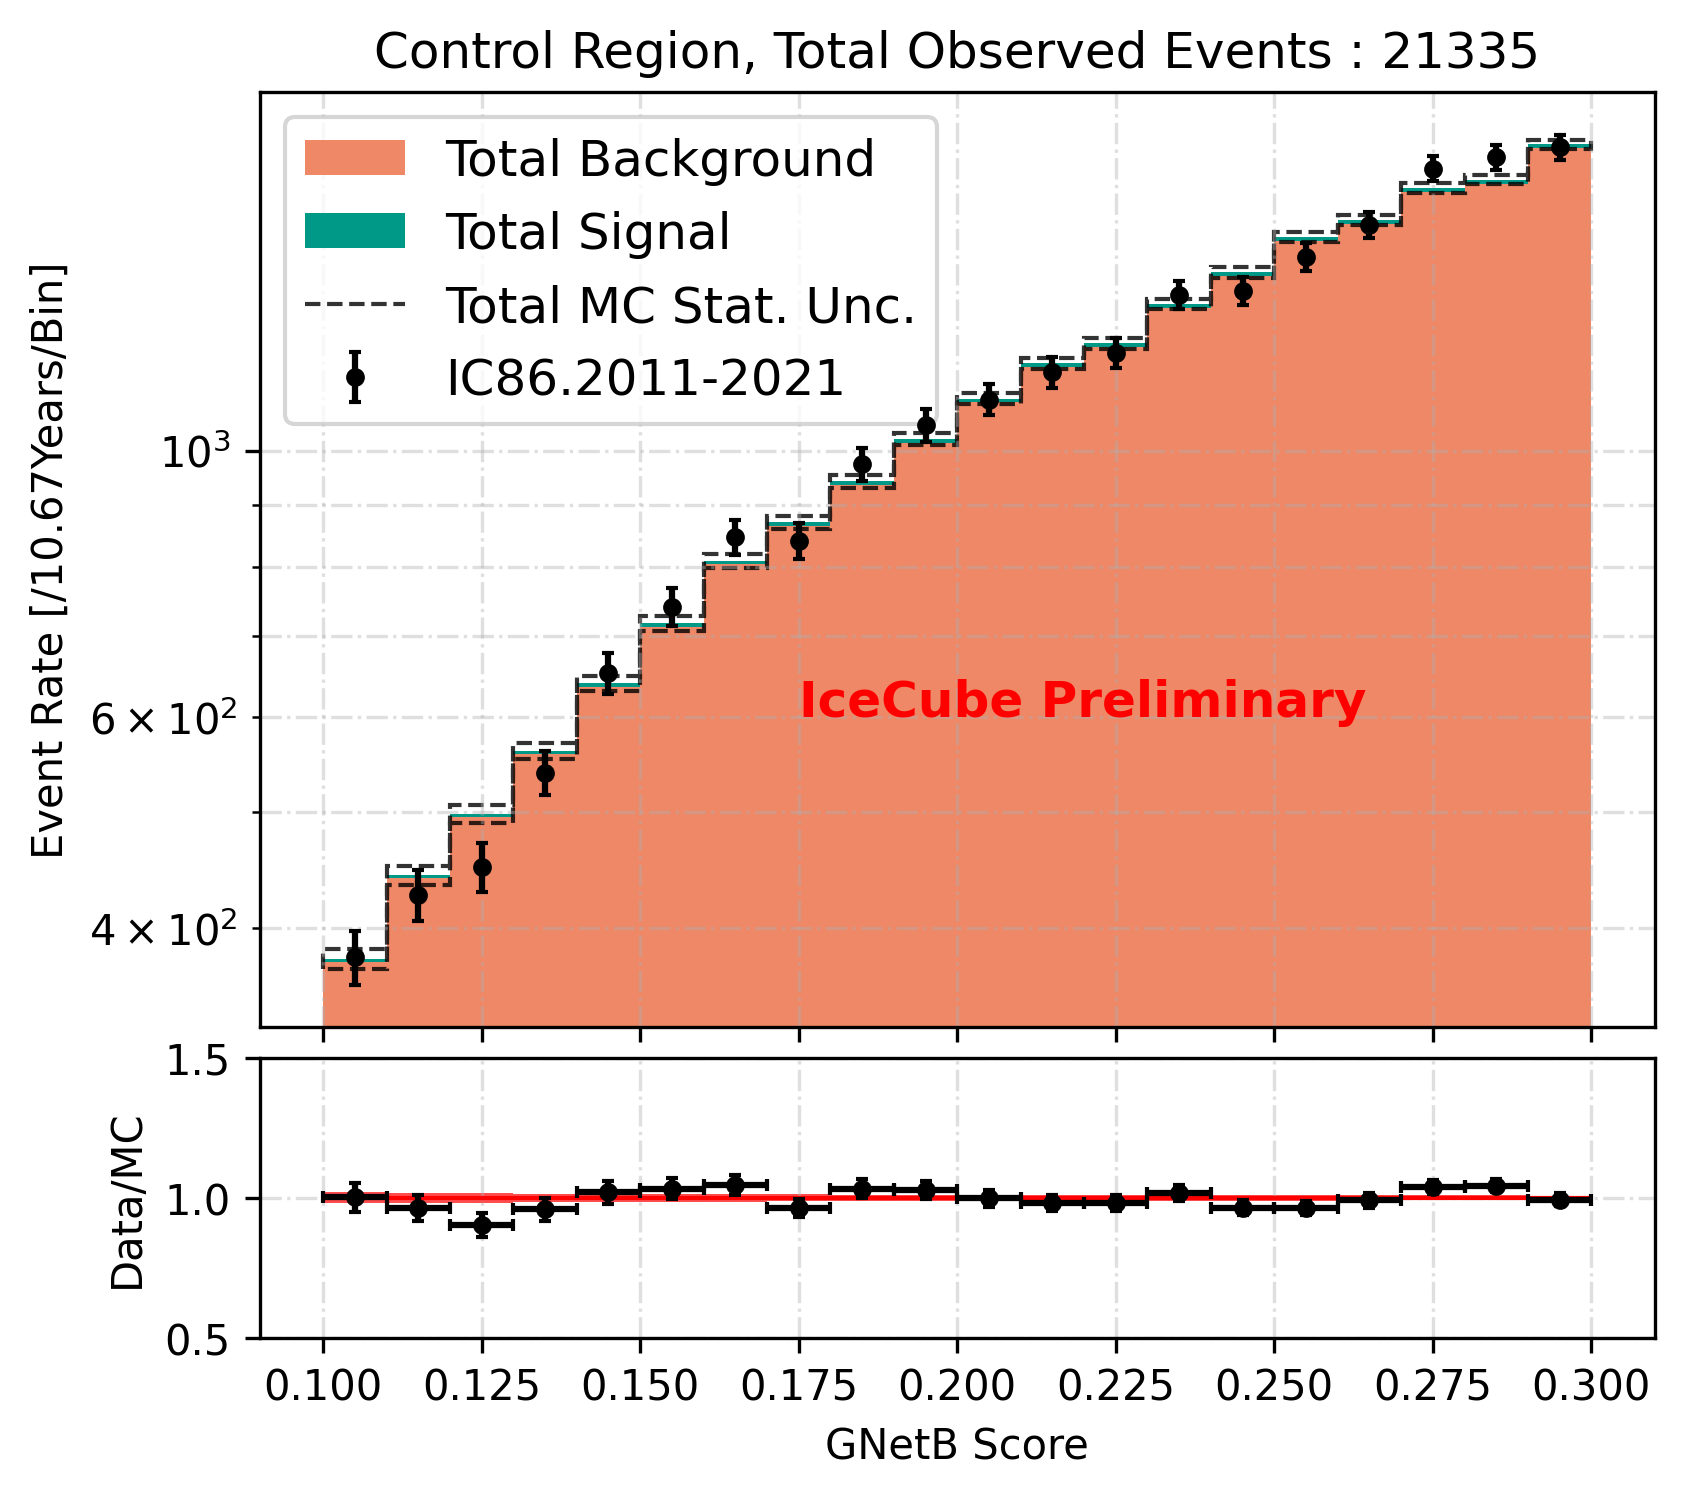

In [357]:
make_histplot('bpred', bbins, sbperr, bbperr,
                  tottime = TIME, 
              bkg_scale = fitsett['bkg_scale'],
              sig_scale=fitsett['sig_scale'],
              plot_err=True, plot_mcerr=True,
              i3label=True,
              **allsett)

# SRs

In [249]:
#define the plot configurations
fname = "../plots/plot_config.json"
with open(fname) as f:
    pltcnf = json.load(f)

#allsett = pltcnf['sr1']
allsett = pltcnf['sr2']

# Note:

To calculate the error bands in Signal Regions, we use the entire ROI as the statistics gets very low in the SRs. Therefore, we select the events in ROI first to compute the error arrays then re-apply the cuts for respective SR for the actual event counts

In [240]:
#Apply ROI cut
reg = config['CutRegions']['ROI']
for process in sig_holder:
    process.reset_cut()
    process.apply_energyCut()
    process.apply_zenithCut()
    process.apply_boxCut(reg[1][0], reg[1][1],
                       amax=reg[1][2], bmax=reg[1][3])

for process in bkg_holder:
    process.reset_cut()
    process.apply_energyCut()
    process.apply_zenithCut()
    process.apply_boxCut(reg[1][0], reg[1][1],
                       amax=reg[1][2], bmax=reg[1][3])

for process in sigsys_holder:
    process.reset_cut()
    process.apply_energyCut()
    process.apply_zenithCut()
    process.apply_boxCut(reg[1][0], reg[1][1],
                       amax=reg[1][2], bmax=reg[1][3])

for process in bkgsys_holder:
    process.reset_cut()
    process.apply_energyCut()
    process.apply_zenithCut()
    process.apply_boxCut(reg[1][0], reg[1][1],
                       amax=reg[1][2], bmax=reg[1][3])


data.reset_cut()
data.apply_energyCut()
data.apply_zenithCut()
data.apply_boxCut(reg[1][0], reg[1][1],
                       amax=reg[1][2], bmax=reg[1][3])

In [241]:
nbins = allsett['nbins']
amin = allsett['amin']
amax = allsett['amax']
bmin = allsett['bmin']
bmax = allsett['bmax']
emin = allsett['emin']
emax = allsett['emax']
zmin = allsett['zmin']
zmax = allsett['zmax']

ebins = np.logspace(np.log10(emin),np.log10(emax),nbins[0]+1)
zbins = np.linspace(zmin,zmax,nbins[1]+1)
abins = np.linspace(amin,amax,nbins[2]+1)
bbins = np.linspace(bmin,bmax,nbins[3]+1)

In [242]:
sigerr = get_totunc_charm(ebins, zbins, abins, bbins)
bkgerr = get_totunc_ccdis(ebins, zbins, abins, bbins)

senerr = get_tot(sigerr[0])
sznerr = get_tot(sigerr[1])
saperr = get_tot(sigerr[2])
sbperr = get_tot(sigerr[3])

benerr = get_tot1(bkgerr[0])
bznerr = get_tot1(bkgerr[1])
baperr = get_tot1(bkgerr[2])
bbperr = get_tot1(bkgerr[3])

In [243]:
reg = config['CutRegions'][allsett['reg']]
for process in sig_holder:
    process.reset_cut()
    process.apply_energyCut()
    process.apply_zenithCut()
    process.apply_curveCut(reg[1][0], reg[1][1],
                       reg[0])

for process in bkg_holder:
    process.reset_cut()
    process.apply_energyCut()
    process.apply_zenithCut()
    process.apply_curveCut(reg[1][0], reg[1][1],
                       reg[0])

for process in sigsys_holder:
    process.reset_cut()
    process.apply_energyCut()
    process.apply_zenithCut()
    process.apply_curveCut(reg[1][0], reg[1][1],
                       reg[0])

for process in bkgsys_holder:
    process.reset_cut()
    process.apply_energyCut()
    process.apply_zenithCut()
    process.apply_curveCut(reg[1][0], reg[1][1],
                       reg[0])


data.reset_cut()
data.apply_energyCut()
data.apply_zenithCut()
data.apply_curveCut(reg[1][0], reg[1][1],
                       reg[0])


In [244]:
def make_srplot(prop, bins, sigerror, bkgerror,
                  tottime = TIME, i3label=False,
                **kwargs):
    #get the binnings for MC
    bincen = 0.5*(bins[1:]+bins[:-1])
    bindiff = np.diff(bins)/2.
    
    b1 = get_hist(bkg_holder[0], prop, bins, tottime)
    b2 = get_hist(bkg_holder[1], prop, bins, tottime)
    b3 = get_hist(bkg_holder[2], prop, bins, tottime)
    b4 = get_hist(bkg_holder[3], prop, bins, tottime)

    s1 = get_hist(sig_holder[0], prop, bins, tottime)
    s2 = get_hist(sig_holder[1], prop, bins, tottime)

    tot = b1+b2+b3+b4+s1+s2
    totbkg = b1+b2+b3+b4
    totsig = s1+s2
    
    totsigup = totsig+s1*sigerror
    totsigdn = totsig-s1*sigerror

    totbkgup = totbkg+b1*bkgerror
    totbkgdn = totbkg-b1*bkgerror
    
    #get the binnings for data
    ndata,_ = np.histogram(data.event_arr[data.event_idx][prop], bins=bins)
    nerr = np.sqrt(ndata)
    
    #Plot
    if 'fsize' in kwargs.keys():
        fig = plt.figure(figsize=tuple(kwargs['fsize']))
    else:
        fig = plt.figure()
        
    #set the x-axis as the baseline to build the stacked stair plots 
    baseline = np.zeros(len(totbkg))

    #plot signal and background stack
    plt.stairs(totbkg+totsig, bins, baseline=totbkg, 
              **kwargs['sig_settings'])

    plt.stairs(totbkg, bins, baseline=baseline, 
               **kwargs['bkg_settings'])

    #errors
    plt.stairs(totsigup+totbkg, bins, baseline=totsigdn+totbkg,
              **kwargs['sunc_settings'])
    plt.stairs(totbkgup, bins, baseline=totbkgdn,
              **kwargs['bunc_settings'])

    #plot data lines
    dxarr = data.event_arr[data.event_idx][prop]
    plt.errorbar(dxarr,
                 np.repeat(0.5, len(dxarr)), yerr=0.5,
                    **kwargs['data_settings'])

    #lcount=0
    #for d in data.event_arr[data.event_idx][prop]:
    #    if lcount==0:
    #        plt.vlines(d, 0,1, label=kwargs['data_label'],
    #                  **kwargs['data_settings'])
    #        lcount+=1
    #        continue       
    #    plt.vlines(d, 0,1, **kwargs['data_settings'])


    plt.grid(**kwargs['grid'])
    axsett = kwargs[prop+'_scale']
    
    if i3label:
        plt.text(axsett['textpos'][0], axsett['textpos'][1],
                "IceCube Preliminary",
                fontsize=12, color='r', fontweight = "extra bold")

    plt.legend(**axsett['legend'])
    plt.xscale(axsett['xscale'])
    plt.yscale(axsett['yscale'])
    plt.xlabel(XLABELS[prop])
    plt.ylabel(axsett['ylabel'])
    
    if (axsett['xmin'] is not None) and axsett['xmax']:
        plt.xlim([axsett['xmin'], axsett['xmax']])
        
    if (axsett['ymin'] is not None) and axsett['ymax']:
        plt.ylim([axsett['ymin'],
                        axsett['ymax']])
        
    plt.show()

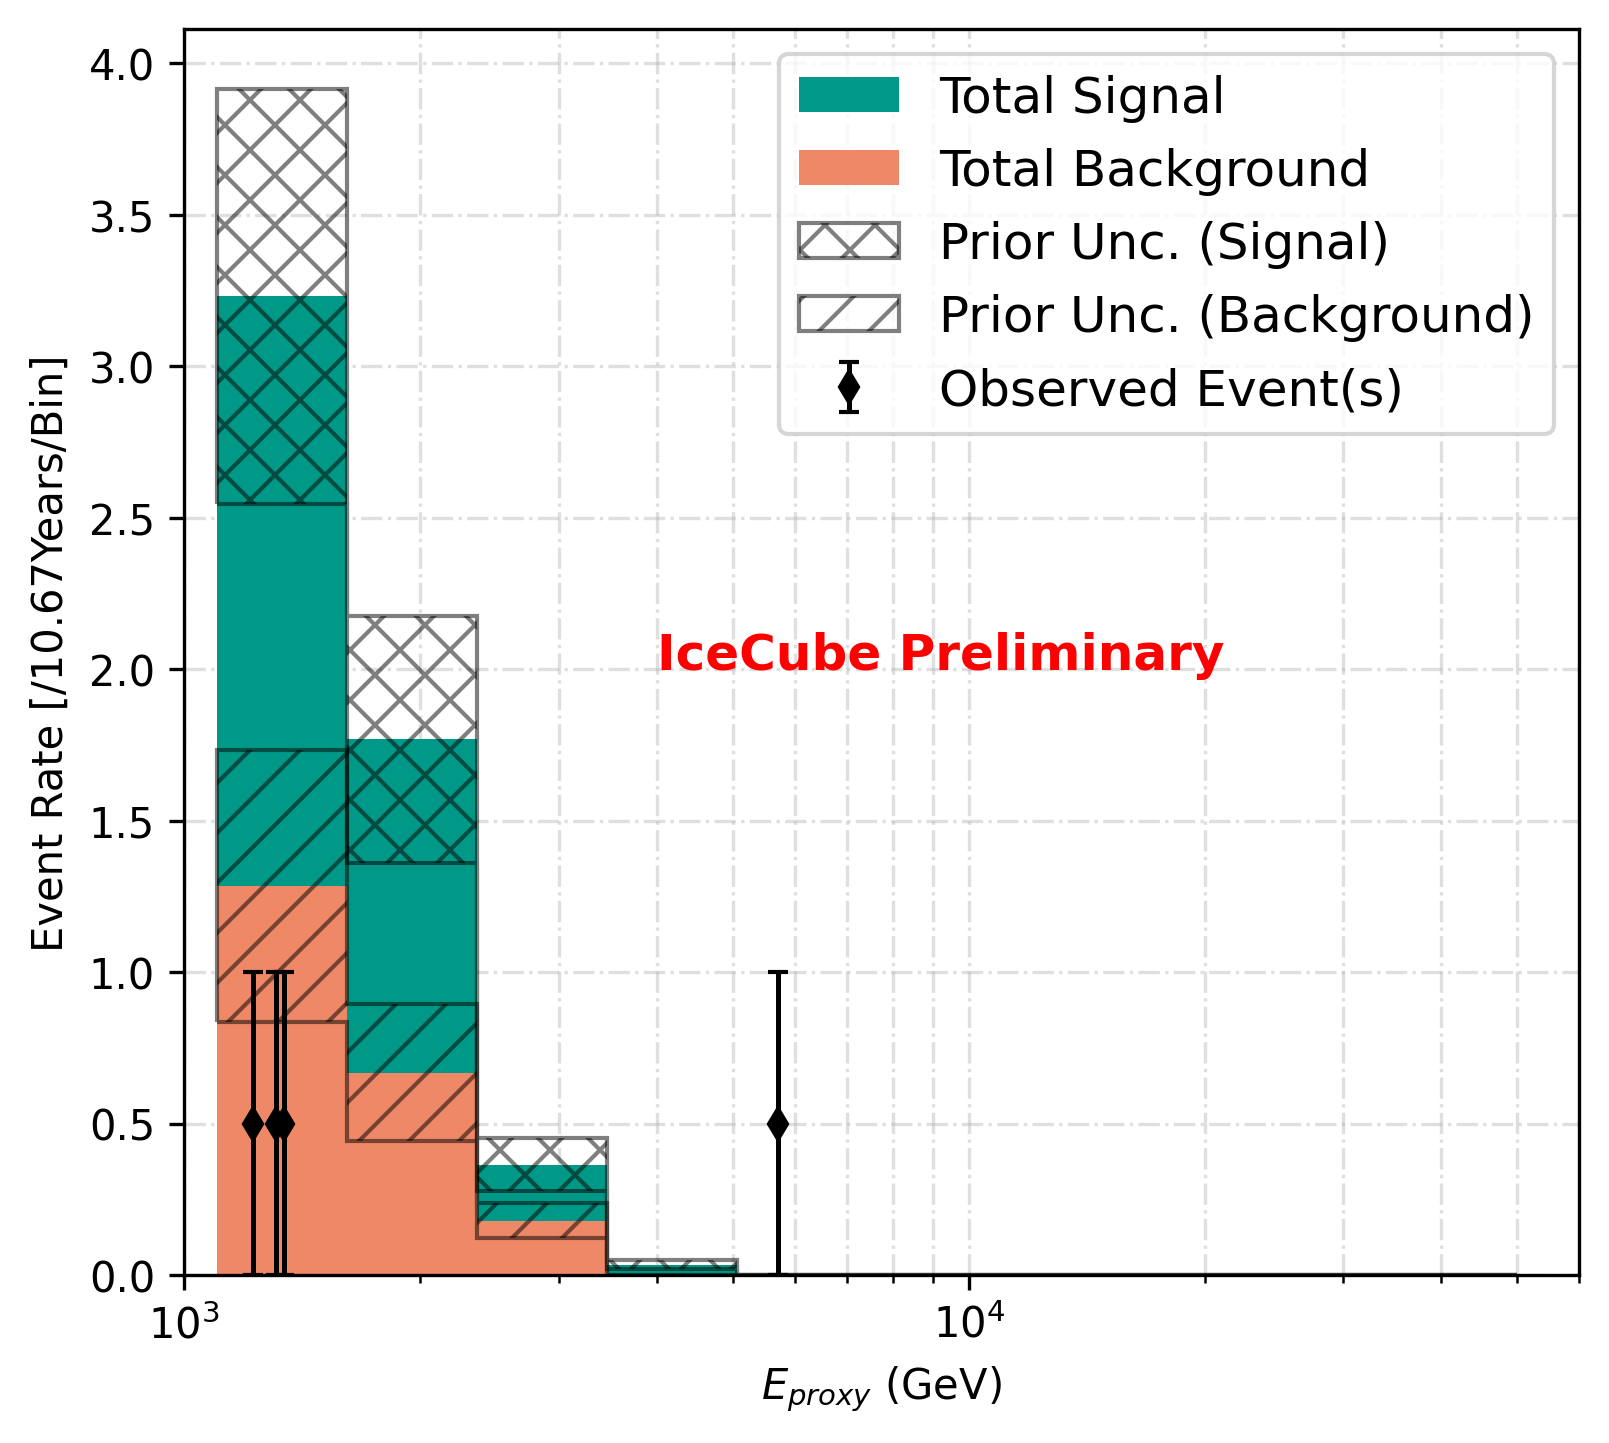

In [250]:
make_srplot('etrack', ebins, senerr, benerr,
                  tottime = TIME, i3label=True, **allsett)

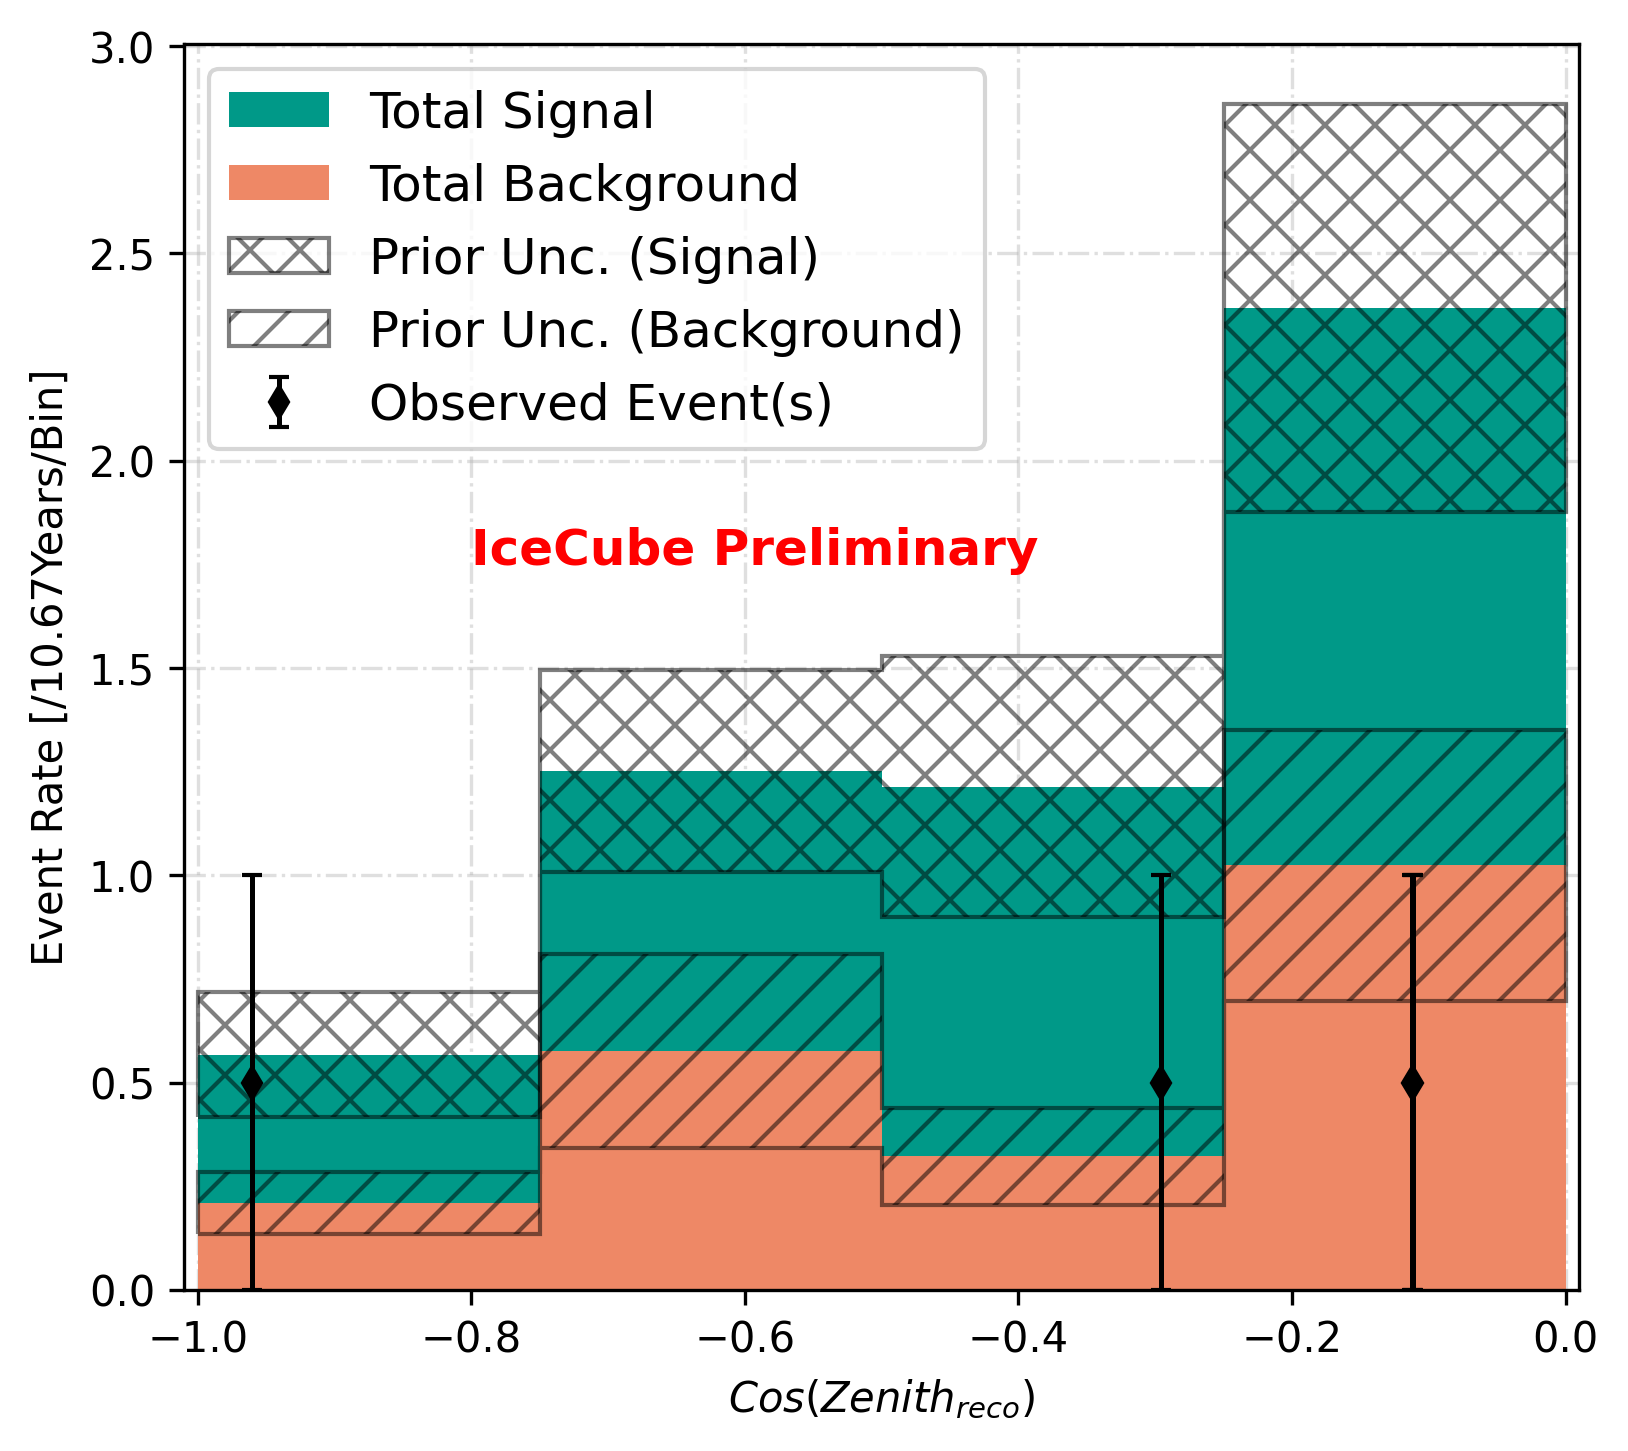

In [251]:
make_srplot('cosz', zbins, sznerr, bznerr,
                  tottime = TIME, i3label=True, **allsett)

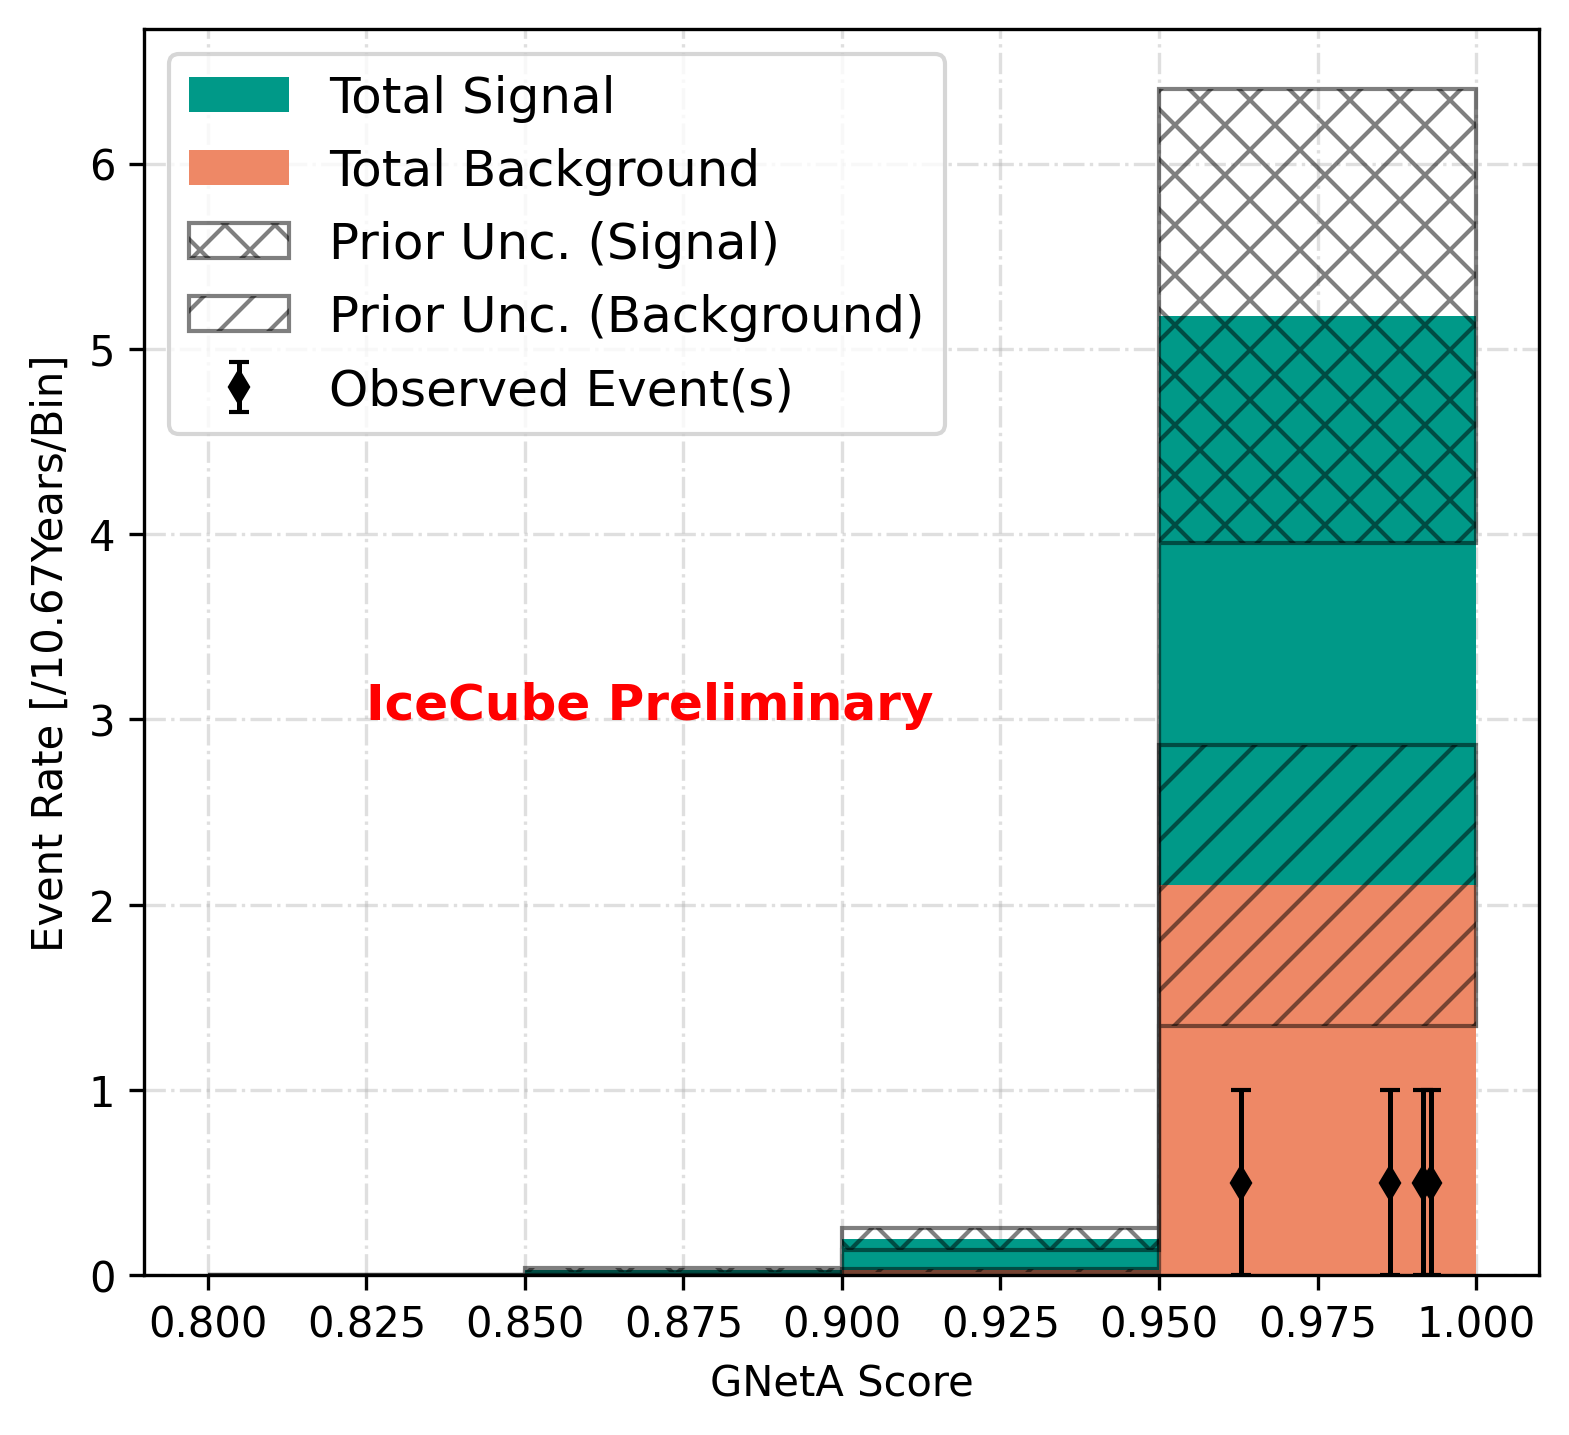

In [252]:
make_srplot('apred', abins, saperr, baperr,
                  tottime = TIME, i3label=True, **allsett)

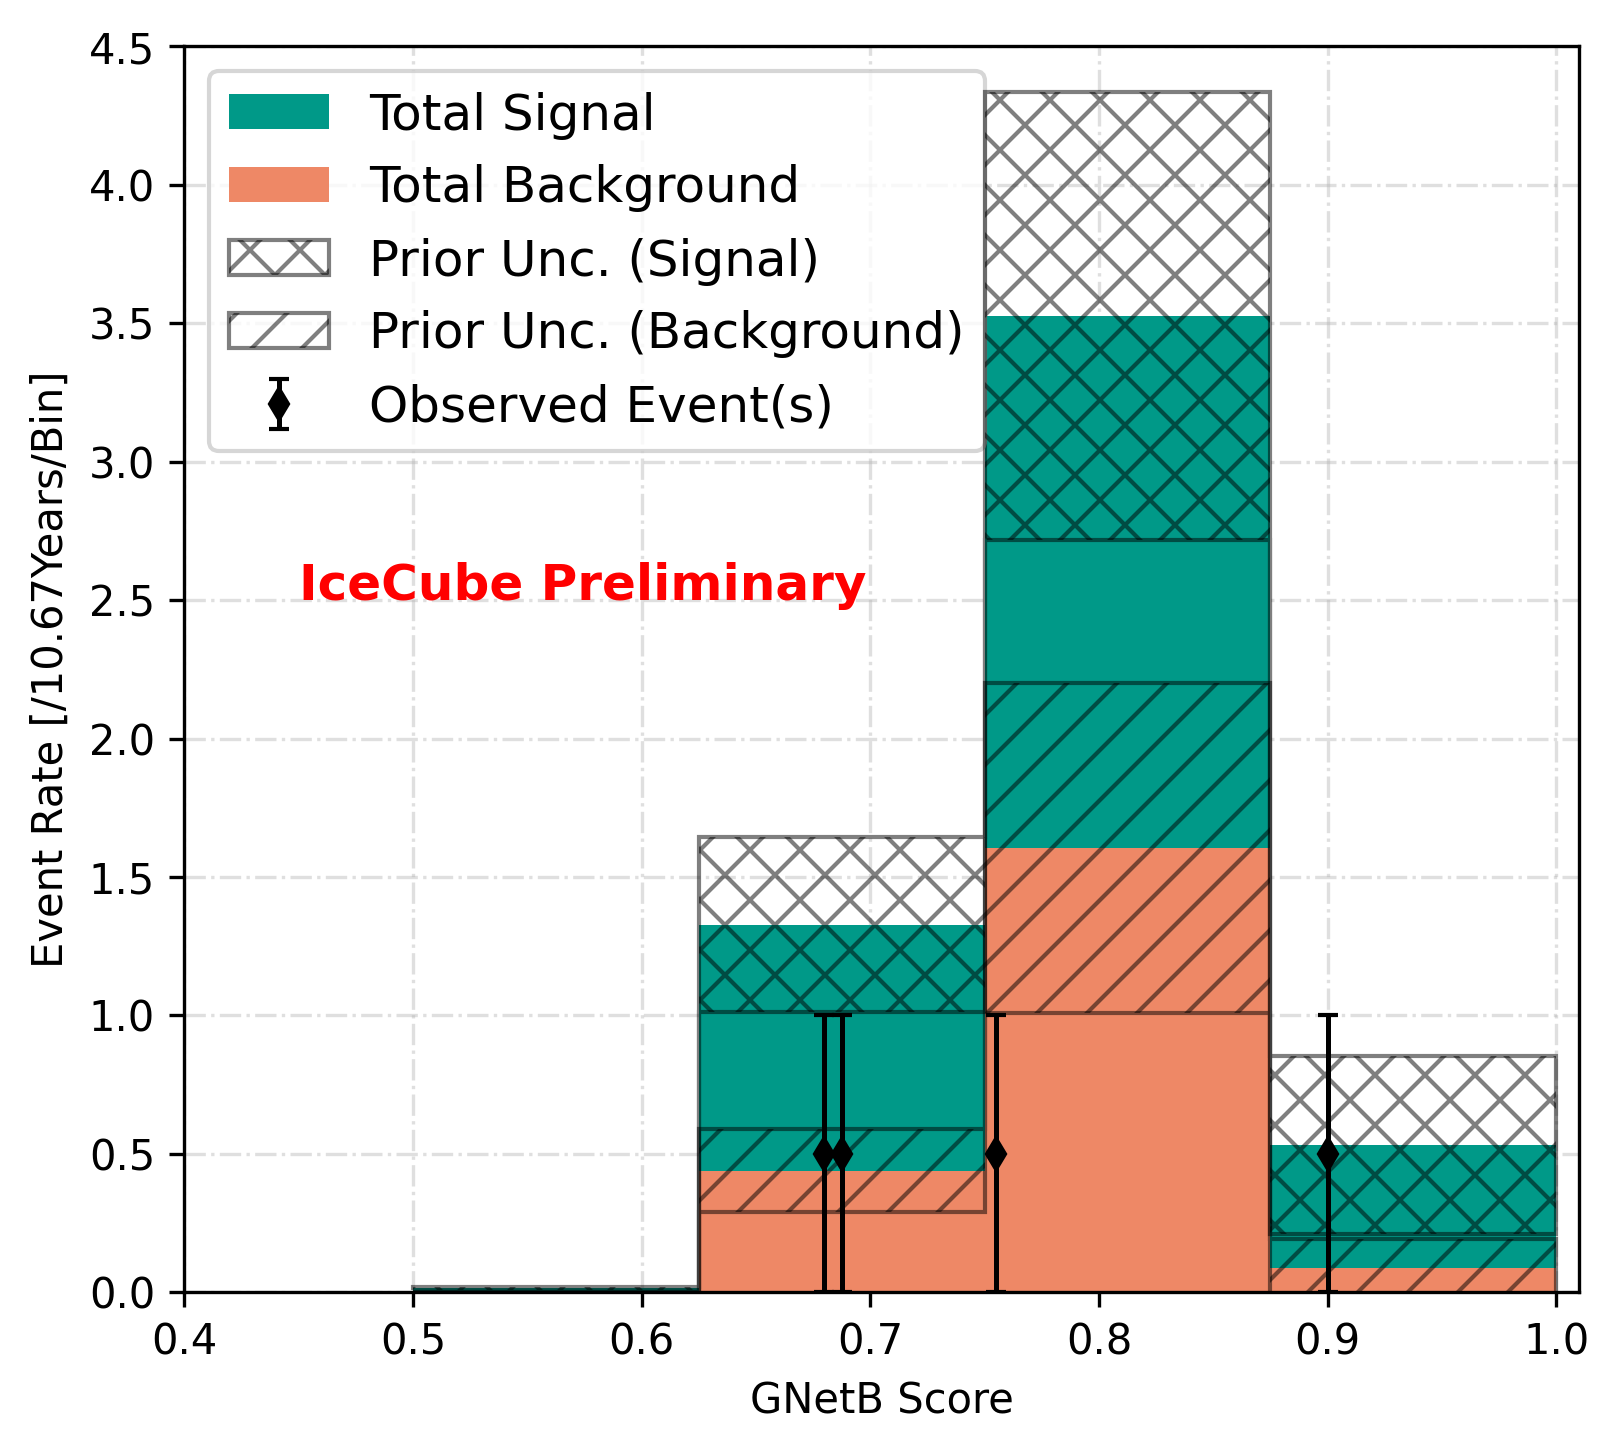

In [253]:
make_srplot('bpred', bbins, sbperr, bbperr,
                  tottime = TIME, i3label=True, **allsett)